In [ ]:
# default_exp funcs.visualization

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Visualization tools 

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope, get_roi_filt_inds, mic_inp_apply_inds, extract_psf_roi
from decode_fish.engine.point_process import PointProcessUniform
from matplotlib.backends.backend_agg import FigureCanvas
from decode_fish.funcs.routines import get_prediction

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
from decode_fish.funcs.exp_specific import get_mop_codebook
cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_17/phasing:0.0/train.yaml')

In [ ]:
cfg.genm.microscope.col_shifts_enabled =  True
cfg.genm.microscope.col_shifts_yxds =  [2048, 2048, 50]

In [ ]:
cfg.training.bs = 1
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
codebook, target = get_mop_codebook()
post_proc.codebook = torch.tensor(codebook)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# export
def get_simulation_statistics(decode_dl, micro, point_process, int_threshold=1, samples = 1):
        
    """
    Draws a sample from the dataloader, and plots a slice of the real volume and the simulated volume.
    """ 
    
    with torch.no_grad():
        
        for _ in range(samples):
        
            xmax = 0
            while xmax <= int_threshold:
                ret_dict = next(iter(decode_dl))
                xmax = ret_dict['x'][0,0,:].max()
                
            x = cpu(ret_dict['x'] * micro.get_ch_mult().detach())
            
            rand_ch = np.random.randint(0,x.shape[1])
            
            sim_vars = point_process.sample(ret_dict['local_rate'][:,0], from_code_book=False)
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1])
            xsim = micro(*ch_inp)
            xsim = micro.noise(xsim, ret_dict['background'] * micro.get_ch_mult().detach()).sample()
            
            sim_df = sample_to_df(*sim_vars[:5], sim_vars[-1], px_size_zyx=[1.,1.,1.])
            sim_df = sim_df[sim_df['frame_idx'] == 0]
            sim_df = sim_df[sim_df[f'int_{rand_ch}'] > 0]
            
            x = x[0,rand_ch]
            xsim = cpu(xsim[0,rand_ch])

            fig1, axes = plot_3d_projections(x, display=False)
            fig2, axes = plot_3d_projections(xsim, display=False)
            scat_3d_projections(axes, sim_df)
            
            figure = combine_figures([fig1,fig2],[f'Channel {rand_ch}','Simulation'], nrows=1, ncols=2, figsize=(20,10))
            figure.suptitle('Max projection', fontsize=15, y=0.9)

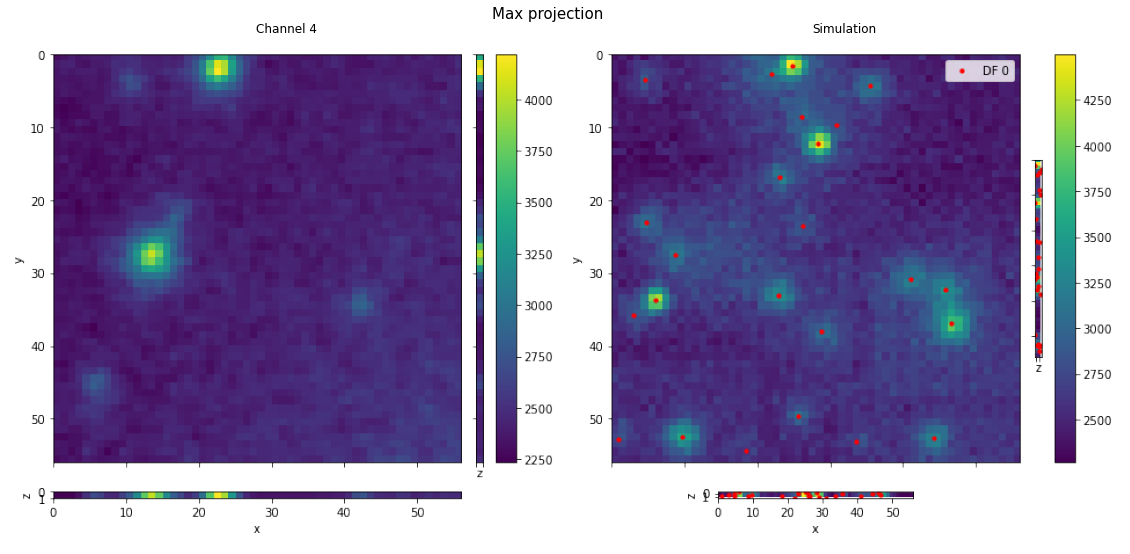

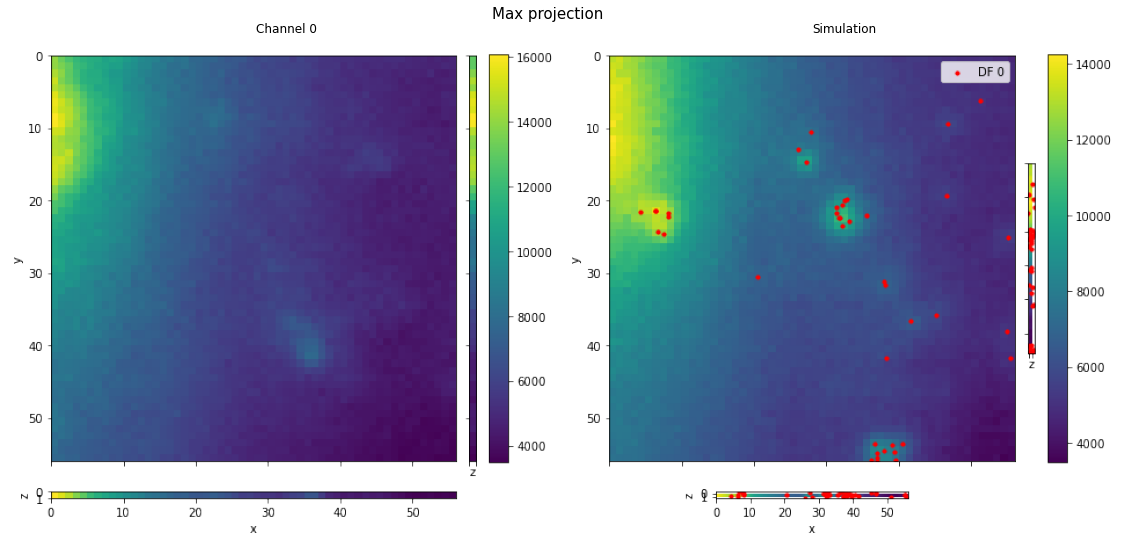

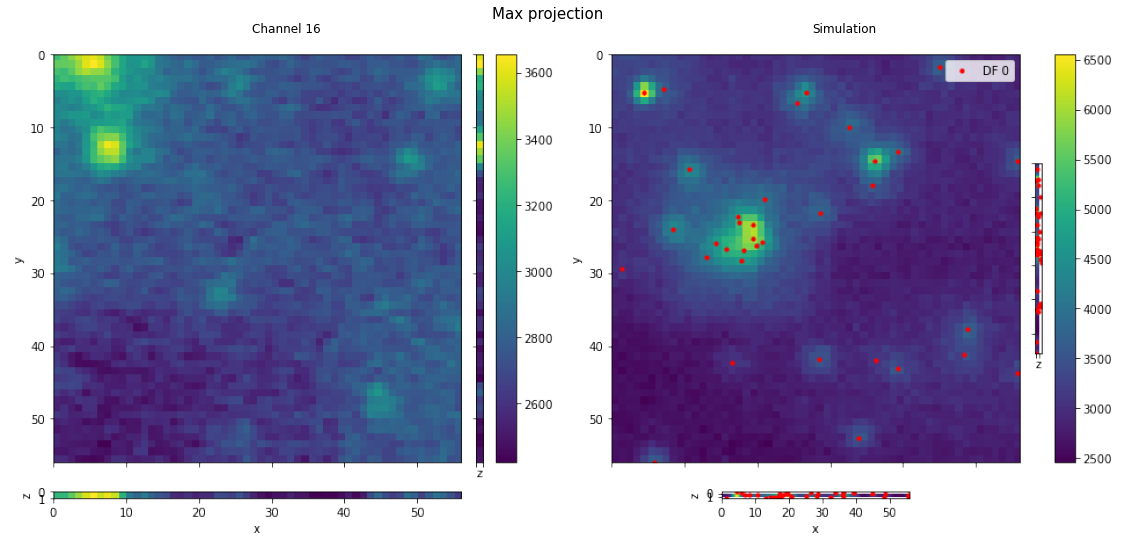

In [ ]:
get_simulation_statistics(decode_dl, micro, **cfg.genm.intensity_dist, int_threshold=0.1, samples=3, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, psf_noise=False)

In [ ]:
# export
def sl_plot(x, xsim, pred_df, target_df, background, res, from_records=True):
    
    pred_df = pred_df[pred_df['frame_idx']==0]
    target_df = target_df[target_df['frame_idx']==0]
    
    with torch.no_grad():
        
        if from_records:
        
            fig = plt.figure(figsize=(20,4))
            plt.subplot(151)
            im = plt.imshow(x[0][0].cpu().numpy().max(0))
            add_colorbar(im)
            plt.axis('off')
            plt.title('Real image')

            plt.subplot(152)
            im = plt.imshow(xsim[0][0].cpu().numpy().max(0))
            plt.scatter(target_df['x'], target_df['y'],facecolors='black', marker='x', s=25.)
            plt.scatter(pred_df['x'], pred_df['y'],facecolors='red', marker='o', s=5.)
            add_colorbar(im)
            plt.axis('off')
            plt.title('Sim. image')

            plt.subplot(153)
            im = plt.imshow(torch.sigmoid(res['logits'][0][0]).cpu().numpy().max(0))
            add_colorbar(im)
            plt.axis('off')
            plt.title('Predicted locations')

            plt.subplot(154)
            im = plt.imshow(background[0][0].cpu().numpy().max(0))
            add_colorbar(im)
            plt.axis('off')
            plt.title('Background')

            plt.subplot(155)
            im = plt.imshow(res['background'][0][0].cpu().numpy().max(0))
            add_colorbar(im)
            plt.axis('off')
            plt.title('Predicted background')
            
        else:
            
            fig = plt.figure(figsize=(10,4))
            
            plt.subplot(121)
            im = plt.imshow(xsim[0][0].cpu().numpy().max(0))
            plt.scatter(target_df['x'], target_df['y'],facecolors='black', marker='x', s=25.)
            plt.scatter(pred_df['x'], pred_df['y'],facecolors='red', marker='o', s=5.)
            add_colorbar(im)
            plt.axis('off')
            plt.title('Sim. image')

            plt.subplot(122)
            im = plt.imshow(torch.sigmoid(res['logits'][0][0]).cpu().numpy().max(0))
            add_colorbar(im)
            plt.axis('off')
            plt.title('Predicted locations')

    return fig

def gt_plot(x, pred_df, gt_df, px_size, gt_rec=None, psf=None, fig_size=(24,6)):

    with torch.no_grad():
        fig = plt.figure(figsize=fig_size)
        plt.subplot(141)
        
        x = x[0].cpu().numpy()
        
        max_proj = x.max(0)
        vmax = max_proj.max()
        im = plt.imshow(max_proj, vmax=vmax)
        add_colorbar(im)
        plt.scatter(pred_df['x'], pred_df['y'],facecolors='red', marker='+', s=20)
#         plt.scatter(gt_df['x'], gt_df['y'],facecolors='none', marker='o', s=20)
        plt.axis('off')
        plt.title('Real image')
        
        if gt_rec is not None:
            
            gt_rec = gt_rec[0].cpu().numpy()
        
            plt.subplot(142)
            im = plt.imshow(gt_rec.max(0), vmax=vmax)
            add_colorbar(im)
            plt.axis('off')
            plt.title('RMSE ' + str(np.round(np.sqrt(((x-gt_rec)**2).mean()),2)))
            
            plt.subplot(143)
            im = plt.imshow(abs(x - gt_rec).max(0))
            add_colorbar(im)
            plt.axis('off')
            
            if psf is not None:
                plt.subplot(144)
                psf_vol = psf.psf_volume[0].detach().cpu().numpy()
                if psf_vol.shape[0] == 1:
                    im = plt.imshow(psf.psf_volume[0].detach().cpu().numpy().mean(0))
                else:
                    im = plt.imshow(psf.psf_volume[0].detach().cpu().numpy().mean(1))
                plt.axis('off')
    
    return fig

In [ ]:
# export
def eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, cuda=False, samples=1, int_threshold=1, plot='rec', crop_sz_xy=40, ret_preds=False, filt_rad=10):
    
    with torch.no_grad():
        
        dl_copy = copy.deepcopy(decode_dl)
        dl_copy.dataset.dataset_tfms[0].crop_sz = (dl_copy.dataset.dataset_tfms[0].crop_sz[0], crop_sz_xy, crop_sz_xy)
        
        if ret_preds: samples = 1
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                ret_dict = next(iter(decode_dl))
                x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
                zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
                background = background * micro.get_ch_mult().detach()
                x = x * micro.get_ch_mult().detach()
                x = x[:1]
                
            if micro.col_shifts_enabled:
                colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, x.shape[-1])
                colshift_crop = colshift_crop[:1]
            else:
                colshift_crop = None
                
            rand_ch = np.random.randint(0, x.shape[1])
            print(rand_ch)
            pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = get_prediction(model, x, post_proc, colshift_crop, micro=micro, cuda=True, return_rec=True, filt_rad=filt_rad)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            
            sub_df = pred_df[cpu(post_proc.codebook)[pred_df['code_inds']][:,rand_ch] > 0]

            x_plot = x[0,rand_ch].cpu().numpy()
            rec = rec[0,rand_ch].cpu().numpy()

            if plot is not None:
            
                fig1, axes = plot_3d_projections(x_plot, proj_func=proj_func, display=False)
                scat_3d_projections(axes, [sub_df])

                if 'res' in plot:

                    diff = x_plot-rec
                    fig2, axes = plot_3d_projections(diff, proj_func=proj_func, display=False)
                    combine_figures([fig1,fig2], ['Predictions', 'Residual'], figsize=(20,10))

                if 'rec' in plot:

                    fig2, axes = plot_3d_projections(rec, proj_func=proj_func, display=False)
                    combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))

                if 'bg' in plot:
                    fig2, axes = plot_3d_projections(res_dict['background'][0,rand_ch].cpu().numpy(), proj_func=proj_func, display=False)
                    combine_figures([fig1,fig2], ['Predictions', 'BG pred.'], figsize=(20,10))
                
            plt.show()
                
        if ret_preds:
            
            return x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp
                        

3


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (28) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


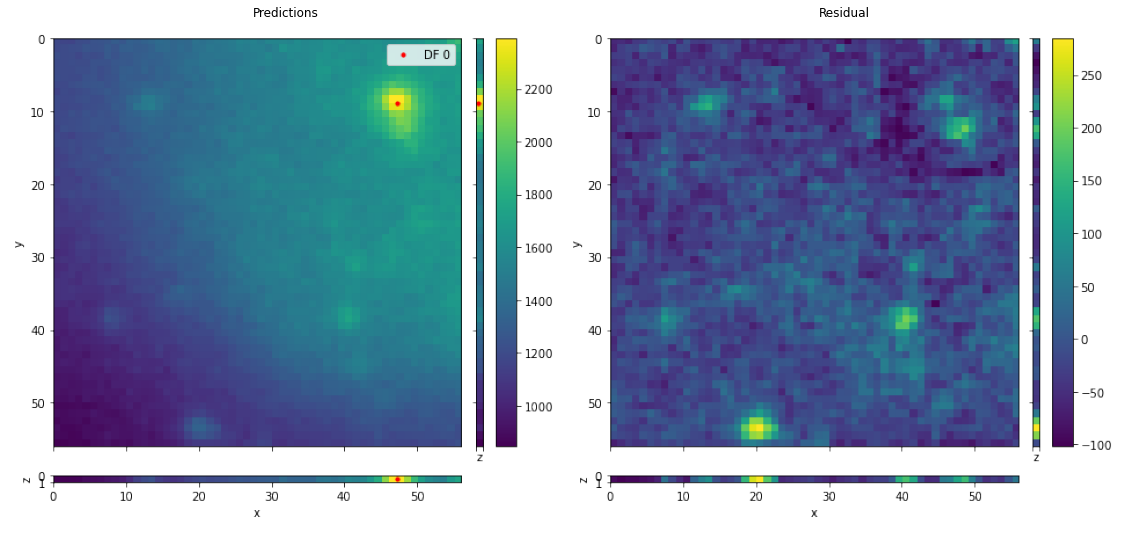

In [ ]:
x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = eval_random_crop(decode_dl, model, post_proc, micro, plot='res', crop_sz_xy=100, ret_preds=True)

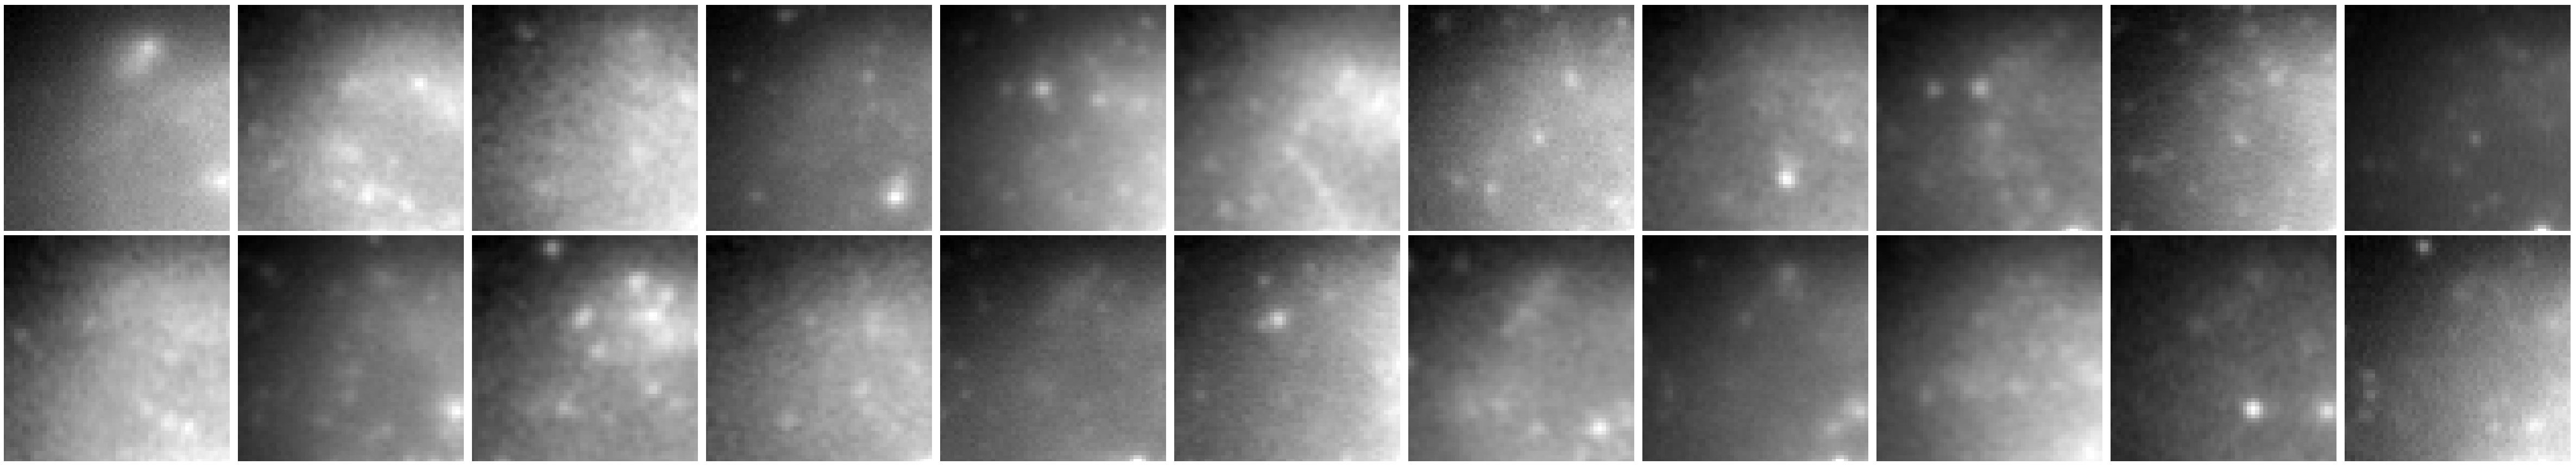

In [ ]:
_ = plot_channels(cpu(x),2)

In [ ]:
# export
def plot_micro_pars(micro, figsize=[24,3]):

    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, sharey=False, figsize=figsize)

    ax1.plot(cpu(micro.channel_facs))
    ax1.set_title('Channel scaling factors')
    ax1.set_xlabel('Channel')

    ax2.plot(cpu(micro.z_facs))
    ax2.set_title('Z factors (PSF scaling)')
    ax2.set_xlabel('Z bin')

    ax3.plot(cpu(micro.theta_par))
    ax3.set_title('Channel theta scaling')
    ax3.set_xlabel('Channel')

    labels = ['x','y','z']
    for i in range(3):
        ax4.plot(cpu(micro.channel_shifts[:,i]), label=labels[i])
    ax4.set_title('Round shifts')
    ax4.set_xlabel('Round')

    im = ax5.imshow(cpu(micro.color_shifts)[0])
    add_colorbar(im)
    ax5.set_title('Color shifts map x')

    im = ax6.imshow(cpu(micro.color_shifts)[1])
    add_colorbar(im)
    ax6.set_title('Color shifts map y')

def plot_slice_psf_pars(micro, gt_psf=None, normed=False, figsize=[32,16]):
    
    psf_vol = abs(cpu(micro.psf.psf_volume))
    psf_init = abs(cpu(micro.psf_init_vol))
    
    if normed:
        psf_vol /= psf_vol.sum(-1).sum(-1)[...,None,None]
        psf_init /= psf_init.sum(-1).sum(-1)[...,None,None]
    
    psf_diff = psf_vol - psf_init
    n_sl = psf_init.shape[1]
    mid_px = psf_init.shape[-1]//2

    f, axes = plt.subplots(2 + 2 * micro.psf.n_cols + (1 if gt_psf is not None else 0), n_sl, sharey=False, figsize=figsize)

    mlist = [psf_init.max().item(), psf_vol.max().item()]
    if gt_psf is not None:
        mlist += [gt_psf.max().item()]
    plt_lim = np.max(mlist)
    
    for z in range(n_sl):

        vmax_z = psf_vol[0:,z].max()
        im = axes[0,z].imshow(psf_init[0,z], vmax=None)
        add_colorbar(im)
        axes[0,z].set_axis_off()
        axes[0,z].margins(x=0, y=0, tight=True)

        axes[-1, z].plot(psf_init[0,z,mid_px], label='Init.')
        axes[-1, z].set_axis_off()
        axes[-1, z].set_ylim(0,plt_lim)

        for n in range(micro.psf.n_cols):

            im = axes[1+2*n,z].imshow(psf_vol[n,z], vmax=None)
            add_colorbar(im)
            axes[1+2*n,z].set_axis_off()
            axes[1+2*n,z].margins(x=0, y=0, tight=True)

            im = axes[2+2*n,z].imshow(psf_diff[n,z], vmax=psf_diff.max(), vmin=psf_diff.min())
            add_colorbar(im)
            axes[2+2*n,z].set_axis_off()
            axes[2+2*n,z].margins(x=0, y=0, tight=True)

            axes[-1, z].plot(psf_vol[n,z,mid_px], label=f'col {n}')
            
        if gt_psf is not None:
            
            if z < len(gt_psf[0]):
                im = axes[-2, z].imshow(gt_psf[n,z], vmax=None)
                add_colorbar(im)
                axes[-1, z].plot(gt_psf[n,z,mid_px], label='gt')

    axes[-1, 0].legend(frameon=False)
    axes[0,0].set_title('Initial PSF', loc='left')
    axes[-1,0].set_title(f'Intensity profile', loc='left')
    
    for n in range(micro.psf.n_cols):
        axes[1+2*n,0].set_title(f'Learned PSF col. {n}', loc='left')
        axes[2+2*n,0].set_title(f'Diff.', loc='left')
        
    if gt_psf is not None:
        axes[-2,0].set_title('GT PSF', loc='left')

In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_3/norm:none//train.yaml')
_,_,micro = load_psf_noise_micro(cfg)
micro.load_state_dict(torch.load(cfg.output.save_dir + '/microscope.pkl'), strict=False)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)

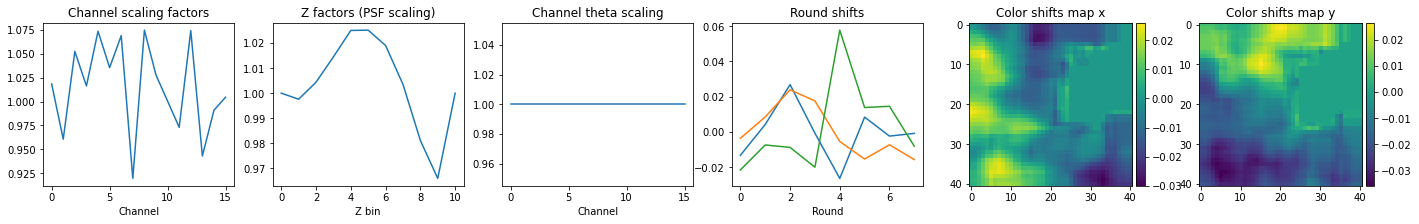

In [ ]:
plot_micro_pars(micro)

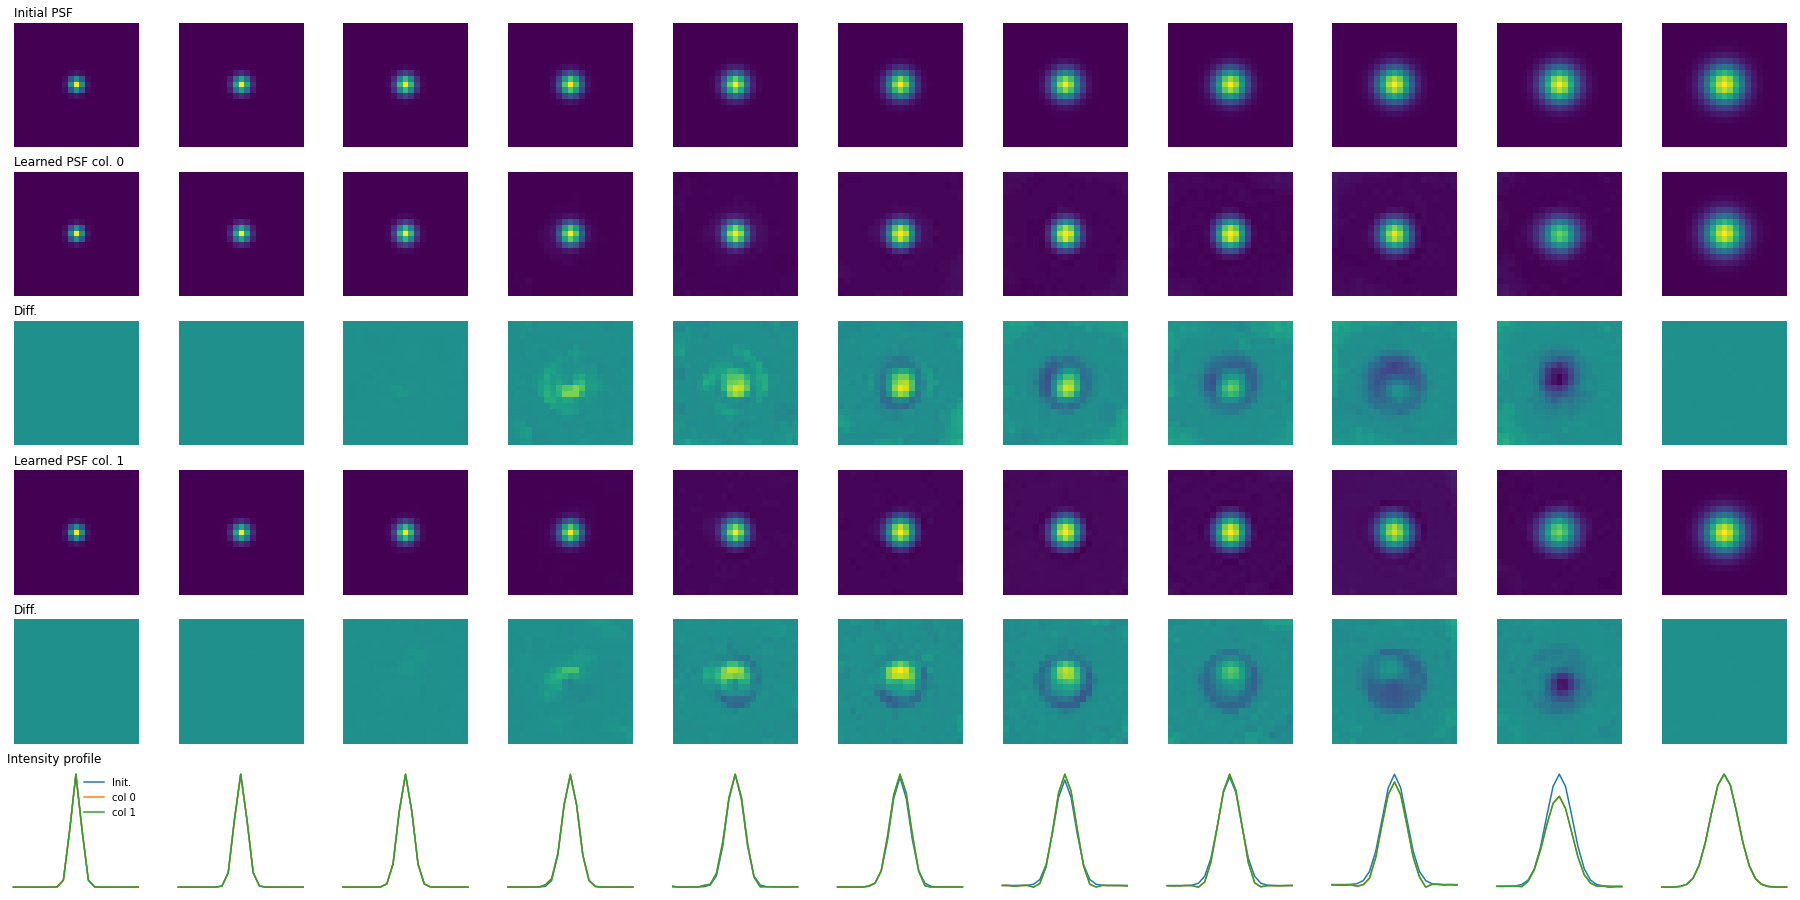

In [ ]:
plot_slice_psf_pars(micro)

In [ ]:
# export
def eval_random_sim(decode_dl, model, post_proc, micro, proj_func=np.max, plot_gt=True, cuda=True, samples=1):
    
    with torch.no_grad():
        
        for _ in range(samples):
        
            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']

            sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, sim_z=True, codebook=torch.tensor(codebook), int_option=cfg.training.int_option).sample(from_code_book=(codebook is not None))
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
            xsim = micro(*ch_inp, add_noise=True)
            
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            sim_df = nm_to_px(sample_to_df(*sim_vars[:-1]))
            sim_df = sim_df[sim_df['frame_idx']==0]

            x = x[0,0].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            fig1, axes = plot_3d_projections(x, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [pred_df])

            fig2, axes = plot_3d_projections(x, proj_func=proj_func, display=False)

            combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))

In [ ]:
eval_random_sim(decode_dl, model, post_proc, micro, proj_func=np.max, samples=3)

RuntimeError: Given groups=1, weight of size [192, 24, 1, 3, 3], expected input[1, 22, 1, 58, 58] to have 24 channels, but got 22 channels instead

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
